# ----------------------------- Summary of Below code -----------------------------------------

## Model With Different Optimizer :


*   GRU with Adam Optimizer ========> Accuracy = 90.16%
*   GRU with RMPS  Optimizer ===========> Accuracy = 86.06%


*   LSTM with Adam Optimizer  ==================> Accuracy = 84.78%
*   LSTM with Nadam Optimzer ==============> Accuracy = 92.17%


## Therefore the best Two model With Higest Accuracy is


*     LSTM with Nadam Optimzer ==============> Accuracy = 92.17%
*     GRU with Adam Optimizer ========> Accuracy = 90.16%








In [13]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
import struct
import pandas as pd
import copy
import cv2
import tensorflow as tf
import tensorflow_hub as hb
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
from google.colab import drive
import matplotlib.image as mpimg
import random
from skimage.filters import prewitt_h, prewitt_v
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import layers, models, regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [14]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
test_path = '/content/drive/My Drive/HCI_PROJECT_2_Dataset/Testing_images'
train_path = '/content/drive/My Drive/HCI_PROJECT_2_Dataset/Training_images'


In [16]:
zip_path = '/content/drive/My Drive/HCI_PROJECT_2_Dataset/HCI_Dataset.zip'

In [17]:
##  # Extracting the word from the filename
def process_nested_dataset(dataset_path, dataset_type):
    data = []
    for root, dirs, files in os.walk(dataset_path):
        for file_name in files:
            if file_name.endswith('.jpg'):
                parts = file_name.split('_')
                if len(parts) >= 2:
                    label = parts[1]
                    file_path = os.path.join(root, file_name)
                    data.append([file_path, label, dataset_type])
    return data

In [18]:


test_data = process_nested_dataset(test_path, 'test')
train_data = process_nested_dataset(train_path,'train');


train_df = pd.DataFrame(train_data, columns=['file_path', 'label', 'dataset_type'])
test_df = pd.DataFrame(test_data, columns=['file_path', 'label', 'dataset_type'])

Processing Train Images:  13%|█▎        | 17843/139440 [06:07<41:41, 48.62it/s]


In [19]:

train_df_split, val_df_split = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df_split)}")
print(f"Validation set size: {len(val_df_split)}")

Training set size: 139440
Validation set size: 34860


In [21]:
def plot_image(file_paths, labels, num_images=3):
    plt.figure(figsize=(28, 28))
    for i in range(num_images):
        idx = random.randint(0, len(file_paths) - 1)
        img_path = file_paths[idx]
        label = labels[idx]


        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        ax = plt.subplot(1, num_images, i + 1)
        ax.title.set_text(f"Label: {label}")
        plt.imshow(img, cmap='gray')

    plt.show()

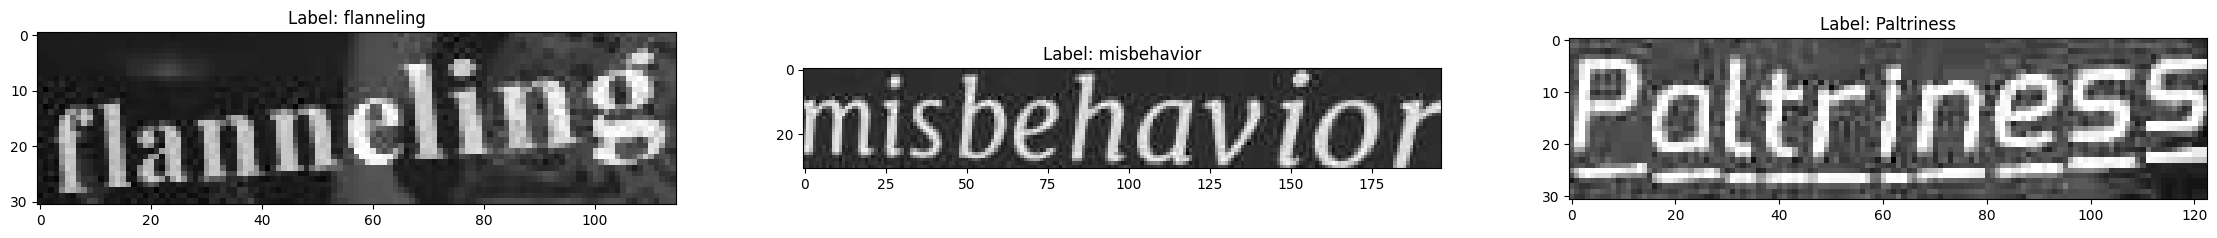

In [22]:
testing_file_paths = test_df['file_path'].values
testing_labels = test_df['label'].values

training_file_paths = train_df['file_path'].values
training_labels = train_df['label'].values
plot_image(testing_file_paths, testing_labels, num_images=3)


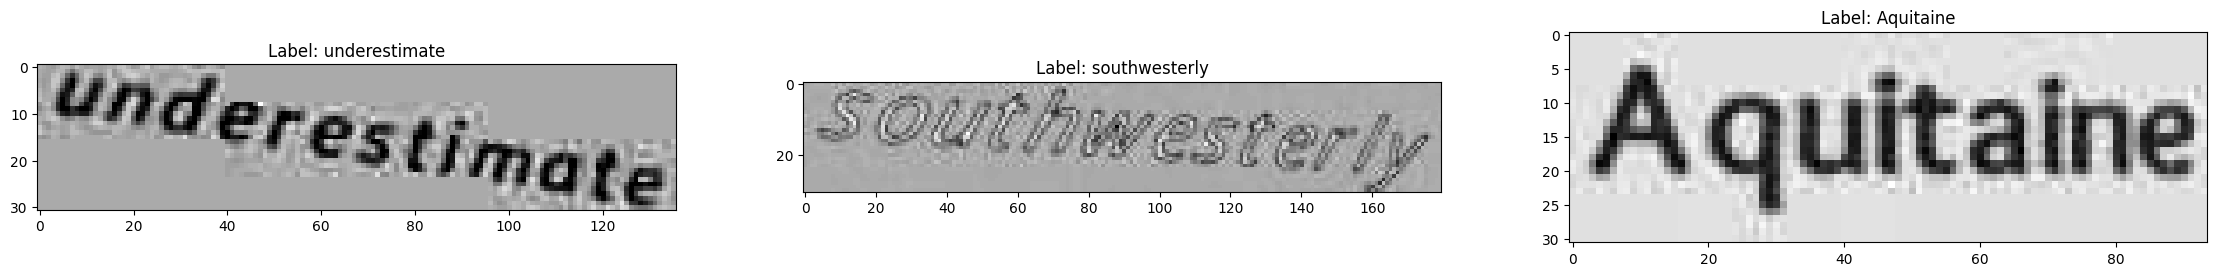

In [ ]:
plot_image(training_file_paths, training_labels, num_images=3)

In [23]:
import cv2
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

def preprocess(img):
    (h, w) = img.shape
    final_img = np.ones([64, 256], dtype=np.uint8) * 255
    aspect_ratio = w / h

    if aspect_ratio > 4:
        new_w = 256
        new_h = int(256 / aspect_ratio)
    else:
        new_h = 64
        new_w = int(64 * aspect_ratio)

    resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    final_img[:new_h, :new_w] = resized_img
    final_img = final_img / 255.0
    return final_img

def process_single_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    processed_img = preprocess(img)
    return processed_img



from tqdm import tqdm
train_file_paths = train_df_split['file_path'].values
train_labels = train_df_split['label'].values

# Using tqdm for progress tracking
train_images_processed = Parallel(n_jobs=-1)(
    delayed(process_single_image)(path) for path in tqdm(train_file_paths, desc="Processing Train Images")
)

# Parallel processing for the validation dataset
val_file_paths = val_df_split['file_path'].values
val_labels = val_df_split['label'].values

val_images_processed = Parallel(n_jobs=-1)(
    delayed(process_single_image)(path) for path in tqdm(val_file_paths, desc="Processing Val Images")
)



train_x_processed = np.stack(train_images_processed).reshape(-1, 64, 256, 1)
valid_x_processed = np.stack(val_images_processed).reshape(-1, 64, 256, 1)

train_y_processed = np.array(train_labels)
valid_y_processed = np.array(val_labels)









Processing Val Images: 100%|██████████| 34860/34860 [10:40<00:00, 54.45it/s]


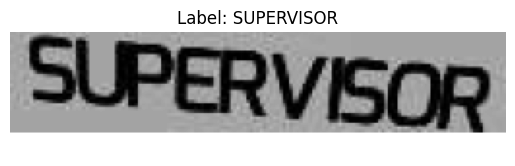

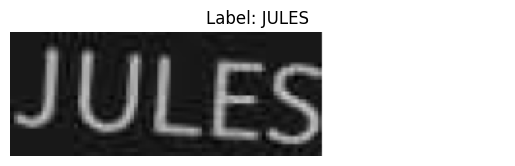

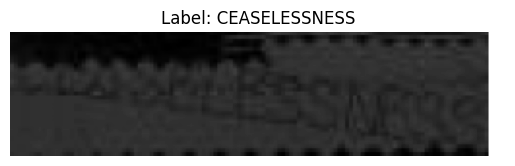

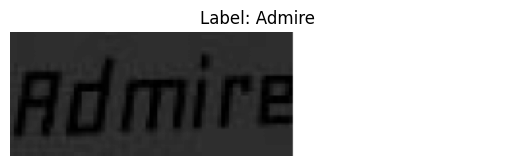

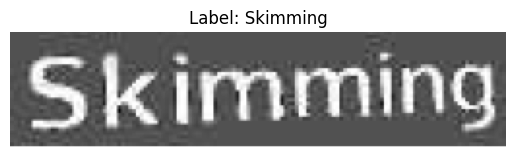

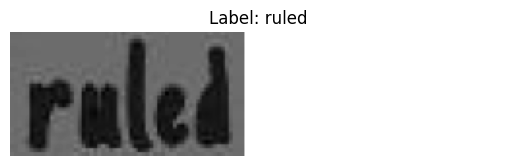

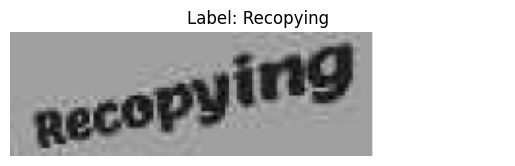

In [26]:
import matplotlib.pyplot as plt


def show_image(image, title=None):
    plt.imshow(image.squeeze(), cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

for i in range(7):
    show_image(train_x_processed[i], title=f"Label: {train_y_processed[i]}")


In [27]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-' "
max_str_len = 24
num_of_characters = len(alphabets) + 1
num_of_timestamps = 24

def label_to_num(label):
    return np.array([alphabets.find(ch) for ch in label if alphabets.find(ch) != -1])

def num_to_label(num):
    return ''.join([alphabets[ch] for ch in num if ch != -1])

def prepare_ctc_data(x, y, max_str_len, num_of_timestamps):
    y_encoded = [label_to_num(label) for label in y]
    y_padded = tf.keras.preprocessing.sequence.pad_sequences(
        y_encoded, maxlen=max_str_len, padding='post', value=-1)

    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y_padded, dtype=tf.int32)
    input_lengths = np.ones((len(x), 1)) * num_of_timestamps
    input_lengths_tensor = tf.convert_to_tensor(input_lengths, dtype=tf.int32)
    label_lengths = np.array([min(len(label), max_str_len) for label in y_encoded])
    label_lengths_tensor = tf.convert_to_tensor(label_lengths, dtype=tf.int32)

    return x_tensor, y_tensor, input_lengths_tensor, label_lengths_tensor

In [28]:
# Training data for CTC
train_x_tensor, train_y_tensor, train_input_lengths, train_label_lengths = prepare_ctc_data(
    train_x_processed, train_y_processed, max_str_len, num_of_timestamps
)

# validation data for CTC
valid_x_tensor, valid_y_tensor, valid_input_lengths, valid_label_lengths = prepare_ctc_data(
    valid_x_processed, valid_y_processed, max_str_len, num_of_timestamps
)

In [35]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2




def build_crnn_model(input_shape, num_of_characters):
    input_data = Input(shape=input_shape, name='input')

    # Convolutional layers
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_data)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((1, 2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((1, 2))(x)
    x = Dropout(0.2)(x)

    # CNN to RNN transition
    x = Reshape((-1, x.shape[-1]))(x)
    x = Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)

    # RNN layers
    x = Bidirectional(GRU(256, return_sequences=True, kernel_regularizer=l2(1e-4), recurrent_regularizer=l2(1e-4)))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(256, return_sequences=True, kernel_regularizer=l2(1e-4), recurrent_regularizer=l2(1e-4)))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(256, return_sequences=True, kernel_regularizer=l2(1e-4), recurrent_regularizer=l2(1e-4)))(x)
    x = Dropout(0.3)(x)

    # Output layer
    x = Dense(num_of_characters, kernel_initializer='he_normal')(x)
    y_pred = Activation('softmax')(x)

    return Model(inputs=input_data, outputs=y_pred)







In [36]:
print(num_of_characters)
print(num_of_timestamps)

66
24


In [37]:
from tensorflow.keras.optimizers import Adam

# def ctc_lambda_func(args):
#     y_pred, labels, input_length, label_length = args
#     y_pred = tf.transpose(y_pred, [1, 0, 2])
#     loss = tf.nn.ctc_loss(
#         labels=labels,
#         logits=y_pred,
#         label_length=tf.squeeze(label_length),
#         logit_length=tf.squeeze(input_length),
#         logits_time_major=True,
#         blank_index=num_of_characters - 1
#     )
#     return tf.reduce_mean(loss)

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, :, :]
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

input_shape = (64, 256, 1)
base_model = build_crnn_model(input_shape, num_of_characters)

labels = Input(name='labels', shape=(max_str_len,), dtype='int32')
input_length = Input(name='input_length', shape=(1,), dtype='int32')
label_length = Input(name='label_length', shape=(1,), dtype='int32')

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [base_model.output, labels, input_length, label_length]
)

model = Model(inputs=[base_model.input, labels, input_length, label_length], outputs=loss_out)
model.compile(optimizer=Adam(learning_rate=0.001), loss={'ctc': lambda y_true, y_pred: y_pred})

In [38]:
train_x_final = train_x_tensor
train_y_final = train_y_tensor
train_input_lengths_final = tf.convert_to_tensor(train_input_lengths, dtype=tf.int32)
train_label_lengths_final = tf.convert_to_tensor(train_label_lengths, dtype=tf.int32)

valid_x_final = valid_x_tensor
valid_y_final = valid_y_tensor
valid_input_lengths_final = tf.convert_to_tensor(valid_input_lengths, dtype=tf.int32)
valid_label_lengths_final = tf.convert_to_tensor(valid_label_lengths, dtype=tf.int32)

In [39]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)


model.compile(optimizer=optimizer, loss={'ctc': lambda y_true, y_pred: y_pred})

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

history = model.fit(
    [train_x_final, train_y_final, train_input_lengths_final, train_label_lengths_final],
    np.zeros(len(train_x_final)),
    batch_size=32,
    epochs=25,
    validation_data=([valid_x_final, valid_y_final, valid_input_lengths_final, valid_label_lengths_final], np.zeros(len(valid_x_final))),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/25
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 427s 94ms/step - loss: 28.2135 - val_loss: 20.6013 - learning_rate: 0.0010
Epoch 2/25
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 407s 93ms/step - loss: 18.3463 - val_loss: 13.2459 - learning_rate: 0.0010
Epoch 3/25
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 407s 93ms/step - loss: 12.5194 - val_loss: 9.6617 - learning_rate: 0.0010
Epoch 4/25
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 407s 93ms/step - loss: 10.5819 - val_loss: 10.4184 - learning_rate: 0.0010
Epoch 5/25
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 407s 93ms/step - loss: 9.6085 - val_loss: 10.2373 - learning_rate: 0.0010
Epoch 6/25
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 407s 93ms/step - loss: 9.0851 - val_loss: 7.8126 - learning_rate: 0.0010
Epoch 7/25
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 407s 93ms/step - loss: 8.7081 - val_loss: 9.9139 - learning_rate: 0.0010
Epoch 8/25
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 408s 94ms/step - loss: 8.4129 - val_loss: 7.6894 - learning_rate: 0.0010
Epoch 9/25
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 407s 93ms/step - loss: 8.2488 

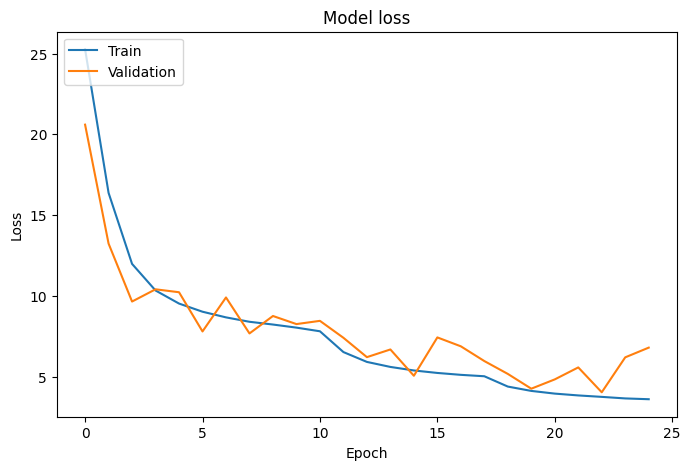

In [40]:
def plot_training_history(history):
    plt.figure(figsize=(8,5))


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


plot_training_history(history)

In [41]:
test_size = 1000
test_x = valid_x_final[:test_size]
test_y = valid_y_final[:test_size]

In [42]:
predictions = base_model.predict(test_x)


input_length = np.ones(predictions.shape[0]) * predictions.shape[1]
results = tf.keras.backend.ctc_decode(predictions,
                                      input_length=input_length,
                                      greedy=True)[0][0]





# decoded = tf.sparse.to_dense(results, default_value=-1).numpy()





32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


In [43]:
decoded_predictions = []
for result in results:
    decoded = num_to_label(result.numpy())
    decoded_predictions.append(decoded)

In [44]:
correct_char = 0
total_char = 0
correct_word = 0
total_word = len(test_y)

for i in range(len(decoded_predictions)):
    pred = decoded_predictions[i]
    true = num_to_label(test_y[i].numpy())

    total_char += len(true)
    correct_char += sum(p == t for p, t in zip(pred, true))

    if pred == true:
        correct_word += 1

char_accuracy = correct_char / total_char * 100
word_accuracy = correct_word / total_word * 100

print(f"Word-level accuracy with adams Optimizer with GRu: {char_accuracy:.2f}%")
#print(f"Word-level accuracy: {word_accuracy:.2f}%")

Word-level accuracy with adams Optimizer with GRu: 90.13%


In [45]:
print("\nSample Predictions and True Labels:")
for i in range(20):
    true_label = num_to_label(test_y[i].numpy())
    print(f"Predicted: '{decoded_predictions[i]}'")
    print(f"True label: '{true_label}'")
    print("-----")


Sample Predictions and True Labels:
Predicted: 'star'
True label: 'starr'
-----
Predicted: 'shadier'
True label: 'shadier'
-----
Predicted: 'Mailed'
True label: 'Mailed'
-----
Predicted: 'CARTY'
True label: 'CARTY'
-----
Predicted: 'THEOSOPHICALL'
True label: 'THEOSOPHICAL'
-----
Predicted: 'TIMBER'
True label: 'TIMBER'
-----
Predicted: 'neutralizersrsrsrsrs'
True label: 'neutralizers'
-----
Predicted: 'assoriment'
True label: 'assortment'
-----
Predicted: 'SUBCLAASSSSSSS'
True label: 'Subclass'
-----
Predicted: 'guardians'
True label: 'guardians'
-----
Predicted: 'HEPARNNNNNN'
True label: 'HEPARIN'
-----
Predicted: 'SAPPER'
True label: 'SADDER'
-----
Predicted: 'lucius'
True label: 'lucius'
-----
Predicted: 'placingssss'
True label: 'placings'
-----
Predicted: 'Lorene'
True label: 'Lorene'
-----
Predicted: 'Hosiery'
True label: 'Hosiery'
-----
Predicted: 'INSIDEEE'
True label: 'INSIDE'
-----
Predicted: 'WIREEL'
True label: 'WIRE'
-----
Predicted: 'GARNISHING'
True label: 'GARNISHING'

In [46]:
import matplotlib.pyplot as plt

decoded_predictions = []
for result in results:
    decoded = num_to_label(result.numpy())
    decoded_predictions.append(decoded)

correct_char = 0
total_char = 0
correct_word = 0
total_word = len(test_y)

for i in range(len(decoded_predictions)):
    pred = decoded_predictions[i]
    true = num_to_label(test_y[i].numpy())

    total_char += len(true)
    correct_char += sum(p == t for p, t in zip(pred, true))

    if pred == true:
        correct_word += 1

char_accuracy = correct_char / total_char * 100
word_accuracy = correct_word / total_word * 100

print(f"Character-level accuracy: {char_accuracy:.2f}%")




Character-level accuracy: 90.13%



Correctly Classified Images:


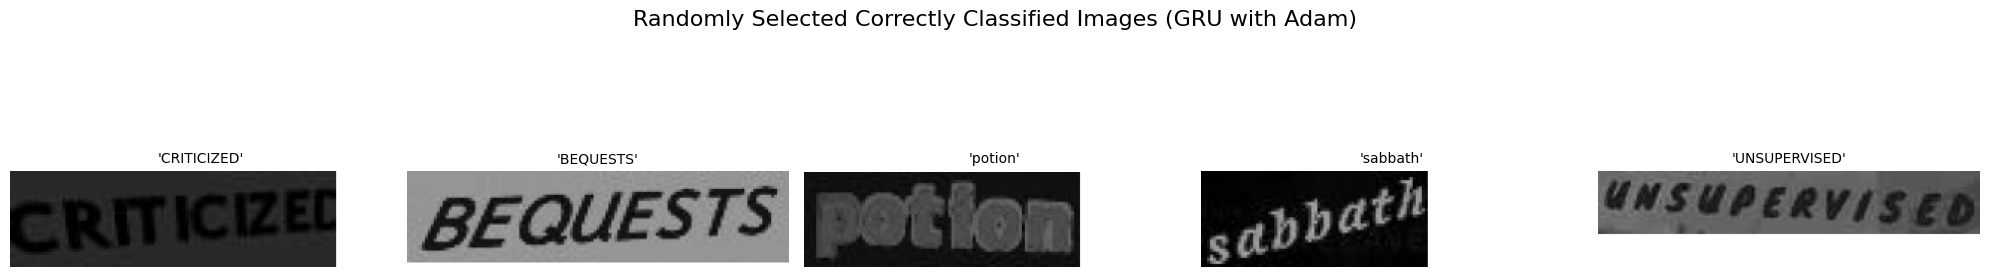

In [47]:
print("\nCorrectly Classified Images:")



fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle("Randomly Selected Correctly Classified Images (GRU with Adam)", fontsize=16)


correct_indices = [i for i in range(len(decoded_predictions)) if decoded_predictions[i] == num_to_label(test_y[i].numpy())]


selected_indices = random.sample(correct_indices, min(5, len(correct_indices)))

for i, idx in enumerate(selected_indices):
    true = num_to_label(test_y[idx].numpy())
    ax = axes[i]
    ax.imshow(test_x[idx].numpy().squeeze(), cmap='gray')
    ax.set_title(f"'{true}'", fontsize=10)
    ax.axis('off')  # Hide axes


for i in range(len(selected_indices), 5):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [48]:

model_save_path_1 = '/content/drive/My Drive/HCI_PROJECT_2_Dataset/Testing_images/model_withGRU_adam.keras'

# Save the model
model.save(model_save_path_1)


/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model.compile(optimizer=optimizer, loss={'ctc': lambda y_true, y_pred: y_pred})

  return {key: serialize_keras_object(value) for key, value in obj.items()}


### ---------------------------------- Using Different Optimizer  RMPS--------------------------------



In [49]:
from tensorflow.keras.optimizers import RMSprop

input_shape = (64, 256, 1)
base_model_RMSprop = build_crnn_model(input_shape, num_of_characters)

labels = Input(name='labels', shape=(max_str_len,), dtype='int32')
input_length = Input(name='input_length', shape=(1,), dtype='int32')
label_length = Input(name='label_length', shape=(1,), dtype='int32')

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [base_model_RMSprop.output, labels, input_length, label_length]
)

model_rmps = Model(inputs=[base_model_RMSprop.input, labels, input_length, label_length], outputs=loss_out)


optimizer_rmps = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07)
model_rmps.compile(optimizer=optimizer_rmps, loss={'ctc': lambda y_true, y_pred: y_pred})

In [50]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# RMSprop optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07)

# Compileing the model with the optimizer
model_rmps.compile(optimizer=optimizer, loss={'ctc': lambda y_true, y_pred: y_pred})

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    )

]

history_1 = model_rmps.fit(
    [train_x_final, train_y_final, train_input_lengths_final, train_label_lengths_final],
    np.zeros(len(train_x_final)),
    batch_size=32,
    epochs=23,
    validation_data=([valid_x_final, valid_y_final, valid_input_lengths_final, valid_label_lengths_final], np.zeros(len(valid_x_final))),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 397s 90ms/step - loss: 30.5191 - val_loss: 24.2661 - learning_rate: 0.0010
Epoch 2/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 390s 89ms/step - loss: 22.1234 - val_loss: 16.0466 - learning_rate: 0.0010
Epoch 3/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 390s 89ms/step - loss: 14.9002 - val_loss: 10.6796 - learning_rate: 0.0010
Epoch 4/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 389s 89ms/step - loss: 11.6133 - val_loss: 9.0938 - learning_rate: 0.0010
Epoch 5/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 389s 89ms/step - loss: 10.2133 - val_loss: 8.5889 - learning_rate: 0.0010
Epoch 6/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 389s 89ms/step - loss: 9.5316 - val_loss: 7.8375 - learning_rate: 0.0010
Epoch 7/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 390s 89ms/step - loss: 9.0877 - val_loss: 8.0238 - learning_rate: 0.0010
Epoch 8/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 390s 89ms/step - loss: 8.7190 - val_loss: 7.7068 - learning_rate: 0.0010
Epoch 9/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 390s 89ms/step - loss: 8.5190 

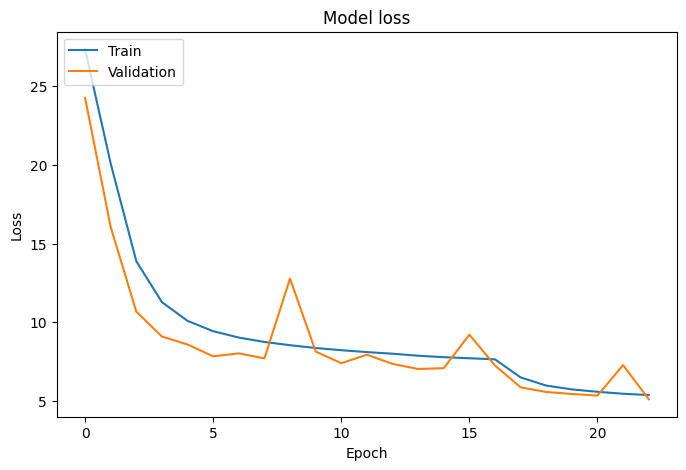

In [51]:
def plot_training_history(history):
    plt.figure(figsize=(8,5))


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


plot_training_history(history_1)

In [52]:
history_1 = model_rmps.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 64, 256, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 64, 256, 64)    │            640 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 64, 256, 64)    │            256 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_14             │ (None, 64, 256, 64)    │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 32, 128, 64)    │              0 │ activation_14[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 32, 128, 64)    │              0 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 32, 128, 128)   │         73,856 │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 32, 128, 128)   │            512 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_15             │ (None, 32, 128, 128)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 16, 64, 128)    │              0 │ activation_15[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 16, 64, 128)    │              0 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 16, 64, 256)    │        295,168 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 16, 64, 256)    │          1,024 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_16             │ (None, 16, 64, 256)    │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 16, 64, 256)    │        590,080 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1

 Total params: 15,125,510 (57.70 MB)

 Trainable params: 7,561,026 (28.84 MB)

 Non-trainable params: 3,456 (13.50 KB)

 Optimizer params: 7,561,028 (28.84 MB)

In [53]:



test_size = 1000
test_x = valid_x_final[:test_size]
test_y = valid_y_final[:test_size]

inference_model = tf.keras.Model(inputs=base_model_RMSprop.input, outputs=base_model_RMSprop.output)

predictions = inference_model.predict(test_x)

print("Predictions shape:", predictions.shape)

# Perform CTC decoding
input_length = np.ones(predictions.shape[0]) * predictions.shape[1]
results = tf.keras.backend.ctc_decode(predictions,
                                      input_length=input_length,
                                      greedy=True)[0][0]

decoded_predictions_1 = []
for result in results:
    decoded = num_to_label(result.numpy())
    decoded_predictions_1.append(decoded)

correct_char = 0
total_char = 0
correct_word = 0
total_word = len(test_y)

for i in range(len(decoded_predictions_1)):
    pred = decoded_predictions_1[i]
    true = num_to_label(test_y[i])
    total_char += len(true)
    correct_char += sum(p == t for p, t in zip(pred, true))

    if pred == true:
        correct_word += 1

char_accuracy = correct_char / total_char * 100
word_accuracy = correct_word / total_word * 100

print(f"Character-level accuracy with RMSprop Optimizer: {char_accuracy:.2f}%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
Predictions shape: (1000, 256, 66)
Character-level accuracy with RMSprop Optimizer: 86.06%



Correctly Classified Images:


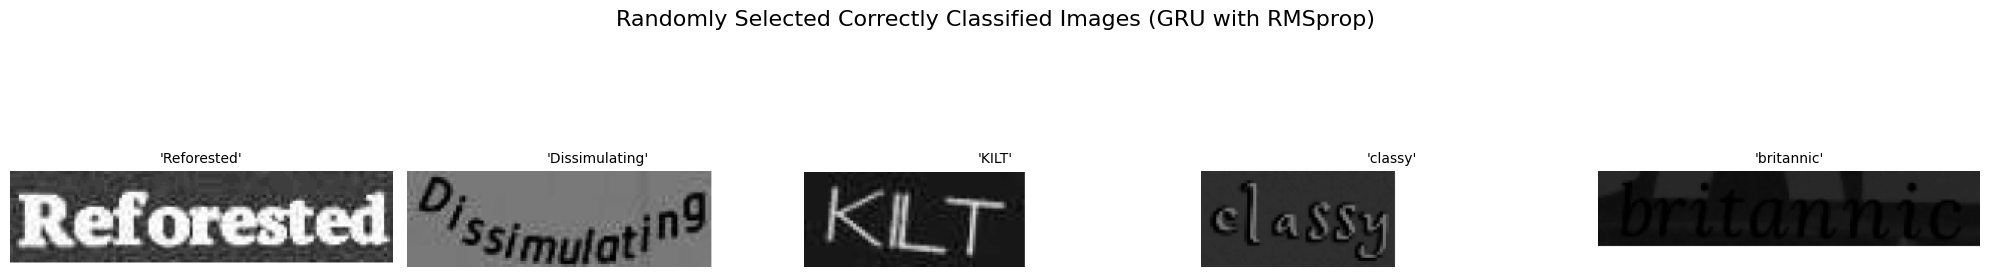

In [54]:
print("\nCorrectly Classified Images:")


n_images = min(5, len(correct_indices))
fig, axes = plt.subplots(1, n_images, figsize=(20, 4))

fig.suptitle("Randomly Selected Correctly Classified Images (GRU with RMSprop)", fontsize=16)

selected_indices = random.sample(correct_indices, n_images)

for i, idx in enumerate(selected_indices):
    true = num_to_label(test_y[idx])
    ax = axes[i]
    ax.imshow(test_x[idx].numpy().squeeze(), cmap='gray')
    ax.set_title(f"'{true}'", fontsize=10)
    ax.axis('off')


if n_images < 5:
    for i in range(n_images, 5):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [55]:

model_save_path_2 = '/content/drive/My Drive/HCI_PROJECT_2_Dataset/Testing_images/model_with_GRU_RMPS.keras'

# Save the model
model_rmps.save(model_save_path_2)


/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model_rmps.compile(optimizer=optimizer, loss={'ctc': lambda y_true, y_pred: y_pred})

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [56]:
model_save_path_2_h5 = '/content/drive/My Drive/HCI_PROJECT_2_Dataset/Testing_images/model_with_GRU_RMPS.h5'

# Save the model
model_rmps.save(model_save_path_2_h5)

### ------------------------------- BIDirection_LSTM  LOGIC-----------------------------------

In [57]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Reshape, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Attention, MultiHeadAttention, LayerNormalization,Multiply




def build_crnn_model_With_LSTM(input_shape, num_of_characters):
    input_data = Input(shape=input_shape, name='input')

    # Convolutional layers
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_data)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((1, 2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((1, 2))(x)
    x = Dropout(0.2)(x)

    # CNN to RNN transition
    x = Reshape((-1, x.shape[-1]))(x)
    x = Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)

    # RNN layers---------------------------------- (Bidirectional LSTM)-------------------------------------------------------------
    x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(1e-4), recurrent_regularizer=l2(1e-4)))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(1e-4), recurrent_regularizer=l2(1e-4)))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(1e-4), recurrent_regularizer=l2(1e-4)))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(1e-4), recurrent_regularizer=l2(1e-4)))(x)
    x = Dropout(0.3)(x)

    # Output layer
    x = Dense(num_of_characters, kernel_initializer='he_normal')(x)
    y_pred = Activation('softmax')(x)

    model = Model(inputs=input_data, outputs=y_pred)

    return model

In [58]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, :, :]
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Model creation and compilation
input_shape = (64, 256, 1)
base_model_1 = build_crnn_model_With_LSTM(input_shape, num_of_characters)

labels = Input(name='labels', shape=(max_str_len,), dtype='int32')
input_length = Input(name='input_length', shape=(1,), dtype='int32')
label_length = Input(name='label_length', shape=(1,), dtype='int32')

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [base_model_1.output, labels, input_length, label_length]
)

model_1 = Model(inputs=[base_model_1.input, labels, input_length, label_length], outputs=loss_out)
model_1.compile(optimizer=Adam(learning_rate=0.001), loss={'ctc': lambda y_true, y_pred: y_pred})



In [59]:
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

history_2 = model_1.fit(
    [train_x_final, train_y_final, train_input_lengths_final, train_label_lengths_final],
    np.zeros(len(train_x_final)),
    batch_size=32,
    epochs=23,
    validation_data=([valid_x_final, valid_y_final, valid_input_lengths_final, valid_label_lengths_final], np.zeros(len(valid_x_final))),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 505s 113ms/step - loss: 30.1233 - val_loss: 25.7049 - learning_rate: 0.0010
Epoch 2/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 493s 113ms/step - loss: 25.5175 - val_loss: 23.5779 - learning_rate: 0.0010
Epoch 3/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 493s 113ms/step - loss: 22.8353 - val_loss: 18.0483 - learning_rate: 0.0010
Epoch 4/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 493s 113ms/step - loss: 17.9783 - val_loss: 13.1107 - learning_rate: 0.0010
Epoch 5/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 493s 113ms/step - loss: 13.6633 - val_loss: 13.5008 - learning_rate: 0.0010
Epoch 6/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 493s 113ms/step - loss: 11.4194 - val_loss: 9.6111 - learning_rate: 0.0010
Epoch 7/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 493s 113ms/step - loss: 10.3914 - val_loss: 8.9179 - learning_rate: 0.0010
Epoch 8/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 493s 113ms/step - loss: 9.7667 - val_loss: 11.2457 - learning_rate: 0.0010
Epoch 9/23
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 493s 113ms/step -

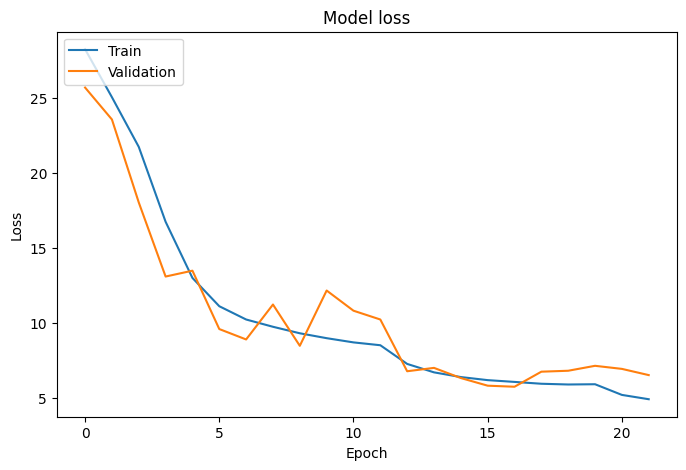

In [60]:
def plot_training_history(history):
    plt.figure(figsize=(8,5))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


plot_training_history(history_2)

In [73]:

# Prepare test data
test_size = 1000
test_x = valid_x_final[:test_size]
test_y = valid_y_final[:test_size]

# Create the inference model
inference_model = tf.keras.Model(inputs=base_model_1.input, outputs=base_model_1.output)

# predictions using the inference model
predictions = inference_model.predict(test_x)


print("Predictions shape:", predictions.shape)


input_length = np.ones(predictions.shape[0]) * predictions.shape[1]
results = tf.keras.backend.ctc_decode(predictions,
                                      input_length=input_length,
                                      greedy=True)[0][0]

decoded_predictions_2 = []
for result in results:
    decoded = num_to_label(result.numpy())
    decoded_predictions_2.append(decoded)

correct_char = 0
total_char = 0
correct_word = 0
total_word = len(test_y)


for i in range(len(decoded_predictions_2)):
    pred = decoded_predictions_2[i]
    true = num_to_label(test_y[i])
    total_char += len(true)
    correct_char += sum(p == t for p, t in zip(pred, true))

    if pred == true:
        correct_word += 1

char_accuracy = correct_char / total_char * 100
word_accuracy = correct_word / total_word * 100


print(f"Character-level accuracy with Adam Optimizer: {char_accuracy:.2f}%")



32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step
Predictions shape: (1000, 256, 66)
Character-level accuracy with Adam Optimizer: 84.50%


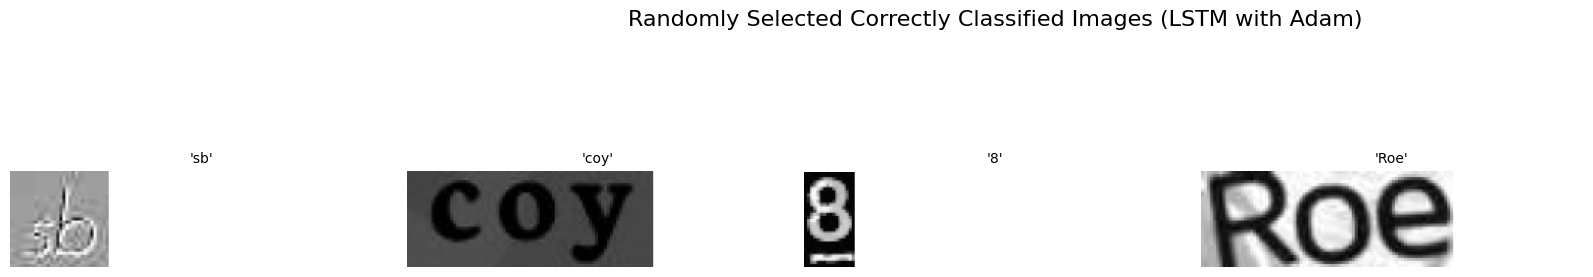

In [79]:


fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle("Randomly Selected Correctly Classified Images (LSTM with Adam)", fontsize=16)

correct_indices = [i for i in range(len(decoded_predictions_2)) if decoded_predictions_2[i] == num_to_label(test_y[i])]

selected_indices = random.sample(correct_indices, min(5, len(correct_indices)))

for i, idx in enumerate(selected_indices):
    true = num_to_label(test_y[idx])
    ax = axes[i]
    ax.imshow(test_x[idx].numpy().squeeze(), cmap='gray')
    ax.set_title(f"'{true}'", fontsize=10)
    ax.axis('off')

for i in range(len(selected_indices), 5):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:

model_save_path_3 = '/content/drive/My Drive/HCI_PROJECT_2_Dataset/Testing_images/model_with_LSTM_adam.keras'

# Save the model
model_1.save(model_save_path_3)


###  --------------------- LSTM WITH Nadam Optimizer ---------------------------


In [64]:
from tensorflow.keras.optimizers import Nadam

In [75]:
input_shape = (64, 256, 1)
base_model_LSTM_2 = build_crnn_model_With_LSTM(input_shape, num_of_characters)

labels = Input(name='labels', shape=(max_str_len,), dtype='int32')
input_length = Input(name='input_length', shape=(1,), dtype='int32')
label_length = Input(name='label_length', shape=(1,), dtype='int32')

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [base_model_LSTM_2.output, labels, input_length, label_length]
)

model_2_LSTM = Model(inputs=[base_model_LSTM_2.input, labels, input_length, label_length], outputs=loss_out)
model_2_LSTM.compile(optimizer=Nadam(learning_rate=0.001), loss={'ctc': lambda y_true, y_pred: y_pred})

In [76]:
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

history_2 = model_2_LSTM.fit(
    [train_x_final, train_y_final, train_input_lengths_final, train_label_lengths_final],
    np.zeros(len(train_x_final)),
    batch_size=64,
    epochs=30,
    validation_data=([valid_x_final, valid_y_final, valid_input_lengths_final, valid_label_lengths_final], np.zeros(len(valid_x_final))),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
2179/2179 ━━━━━━━━━━━━━━━━━━━━ 349s 154ms/step - loss: 29.4682 - val_loss: 25.0958 - learning_rate: 0.0010
Epoch 2/30
2179/2179 ━━━━━━━━━━━━━━━━━━━━ 335s 154ms/step - loss: 23.5386 - val_loss: 19.5988 - learning_rate: 0.0010
Epoch 3/30
2179/2179 ━━━━━━━━━━━━━━━━━━━━ 335s 154ms/step - loss: 16.9850 - val_loss: 14.2557 - learning_rate: 0.0010
Epoch 4/30
2179/2179 ━━━━━━━━━━━━━━━━━━━━ 335s 154ms/step - loss: 11.5724 - val_loss: 11.6381 - learning_rate: 0.0010
Epoch 5/30
2179/2179 ━━━━━━━━━━━━━━━━━━━━ 334s 153ms/step - loss: 9.3361 - val_loss: 8.1143 - learning_rate: 0.0010
Epoch 6/30
2179/2179 ━━━━━━━━━━━━━━━━━━━━ 334s 153ms/step - loss: 8.3191 - val_loss: 8.3211 - learning_rate: 0.0010
Epoch 7/30
2179/2179 ━━━━━━━━━━━━━━━━━━━━ 335s 154ms/step - loss: 7.8116 - val_loss: 9.0888 - learning_rate: 0.0010
Epoch 8/30
2179/2179 ━━━━━━━━━━━━━━━━━━━━ 335s 154ms/step - loss: 7.4958 - val_loss: 6.8552 - learning_rate: 0.0010
Epoch 9/30
2179/2179 ━━━━━━━━━━━━━━━━━━━━ 335s 154ms/step - loss

In [81]:
inference_model_LSTM = Model(inputs=base_model_LSTM_2.input, outputs=base_model_LSTM_2.output)

# Prepare test data
test_size = 1000
test_x = valid_x_final[:test_size]
test_y = valid_y_final[:test_size]


predictions_LSTM = inference_model_LSTM.predict(test_x)


print("Predictions shape:", predictions_LSTM.shape)

input_length = np.ones(predictions_LSTM.shape[0]) * predictions_LSTM.shape[1]
results_LSTM = tf.keras.backend.ctc_decode(predictions_LSTM,
                                           input_length=input_length,
                                           greedy=True)[0][0]

decoded_predictions_LSTM = []
for result in results_LSTM:
    decoded = num_to_label(result.numpy())
    decoded_predictions_LSTM.append(decoded)

correct_char = 0
total_char = 0
correct_word = 0

total_word = len(test_y)

for i in range(len(decoded_predictions_LSTM)):
    pred = decoded_predictions_LSTM[i]

    true = num_to_label(test_y[i])

    total_char += len(true)
    correct_char += sum(p == t for p, t in zip(pred, true))

    if pred == true:
        correct_word += 1

char_accuracy_LSTM = correct_char / total_char * 100
word_accuracy_LSTM = correct_word / total_word * 100

print(f"Character-level accuracy with Nadam Optimizer and LSTM (model_2_LSTM): {char_accuracy_LSTM:.2f}%")





32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
Predictions shape: (1000, 256, 66)
Character-level accuracy with Nadam Optimizer and LSTM (model_2_LSTM): 92.17%



Randomly Selected Correctly Classified Images:


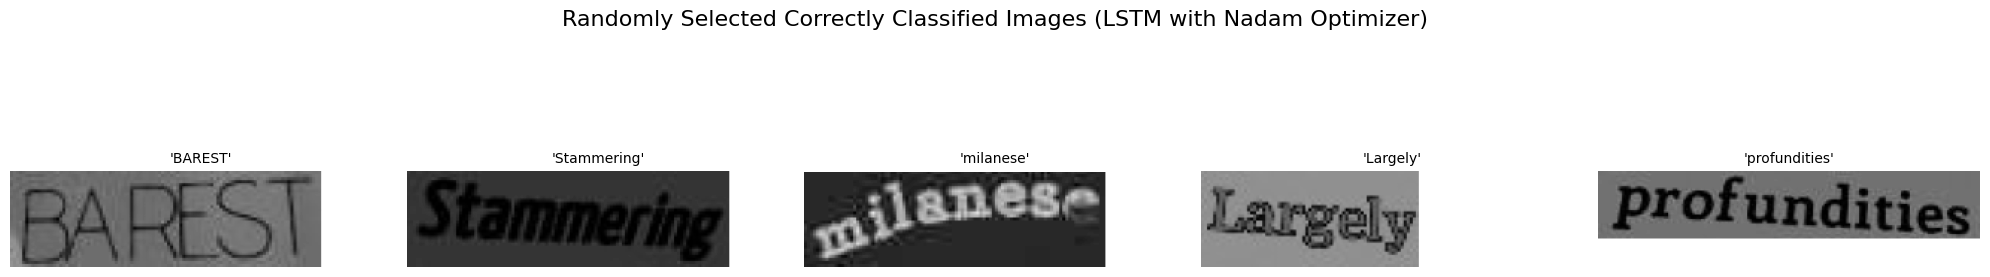

In [71]:
import matplotlib.pyplot as plt
import random

print("\nRandomly Selected Correctly Classified Images:")

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle("Randomly Selected Correctly Classified Images (LSTM with Nadam Optimizer)", fontsize=16)


correct_indices = [i for i in range(len(decoded_predictions_LSTM)) if decoded_predictions_LSTM[i] == num_to_label(test_y[i])]


selected_indices = random.sample(correct_indices, min(5, len(correct_indices)))


for i, idx in enumerate(selected_indices):
    true = num_to_label(test_y[idx])
    ax = axes[i]
    ax.imshow(test_x[idx].numpy().squeeze(), cmap='gray')
    ax.set_title(f"'{true}'", fontsize=10)
    ax.axis('off')


if len(selected_indices) < 5:
    for i in range(len(selected_indices), 5):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [78]:

model_save_path_4 = '/content/drive/My Drive/HCI_PROJECT_2_Dataset/Testing_images/model_with_LSTM_Nadam.keras'

# Save the model
model_2_LSTM.save(model_save_path_4)


/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model_2_LSTM.compile(optimizer=Nadam(learning_rate=0.001), loss={'ctc': lambda y_true, y_pred: y_pred})

  return {key: serialize_keras_object(value) for key, value in obj.items()}


## Model With Different Optimizer :


*   GRU with Adam Optimizer ========> Accuracy = 90.16%
*   GRU with RMPS  Optimizer ===========> Accuracy = 86.06%


*   LSTM with Adam Optimizer  ==================> Accuracy = 84.78%
*   LSTM with Nadam Optimzer ==============> Accuracy = 92.17%


## Therefore the best Two model With Higest Accuracy is


*     LSTM with Nadam Optimzer ==============> Accuracy = 92.17%
*     GRU with Adam Optimizer ========> Accuracy = 90.16%






